Inspecting and Explaining Models
===

Author: Nathan A. Mahynski

Date: 2023/09/12

Description: How can we inspect models and explain their predictions?

In [6]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !pip install git+https://github.com/mahynski/pychemauth@main
    
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [300]:
import sklearn

import numpy as np
import pandas as pd
import seaborn as sns

from pychemauth.classifier.plsda import PLSDA
from pychemauth.classifier.simca import SIMCA_Authenticator
from pychemauth.preprocessing.feature_selection import CollinearFeatureSelector

from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import partial_dependence, permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [13]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

json      : 2.0.9
matplotlib: 3.7.2
sklearn   : 1.3.0
numpy     : 1.24.4
watermark : 2.4.3
pychemauth: 0.0.0b3



<h3>Load the Data</h3>

In [14]:
from sklearn.datasets import load_wine as load_data
X, y = load_data(return_X_y=True, as_frame=True)

In [15]:
# Here we have 3 different classes of wine 
np.unique(y)

array([0, 1, 2])

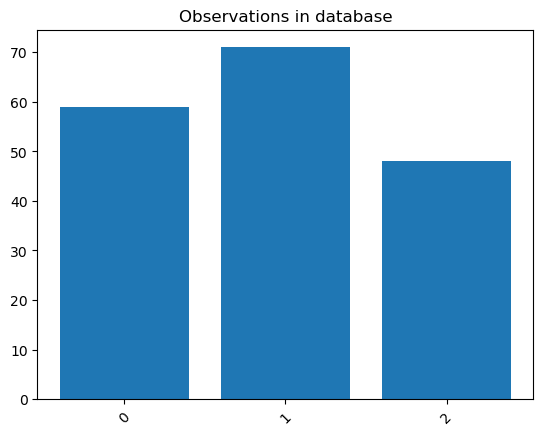

In [21]:
plt.bar(
    x=np.unique(y),
    height=[np.sum(y == class_) for class_ in np.unique(y)]
)
plt.xticks([0, 1, 2])
plt.title('Observations in database')
_ = plt.xticks(rotation=45)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values, # Let's try to predict the salary based on the other numerical features.
    shuffle=True,
    random_state=42,
    test_size=0.2,
    stratify=y # It is usually important to balance the test and train set so they have the same fraction of classes
)

Model Performance
---
Conventional classifiers can be characterized by a number of [metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics); however, because of their ability to predict that a sample is "None" of the known classes, authenticators often use different metrics to score their performance.  As a baseline, let's consider the performance of a Hard PLS-DA model which functions like a conventional classifier.

In [110]:
hard_plsda = PLSDA(
    n_components=2,
    alpha=0.05,
    gamma=0.01,
    not_assigned=-1,
    style='hard',
    scale_x=True,
    score_metric='TEFF'
)

_ = hard_plsda.fit(X_train, y_train)

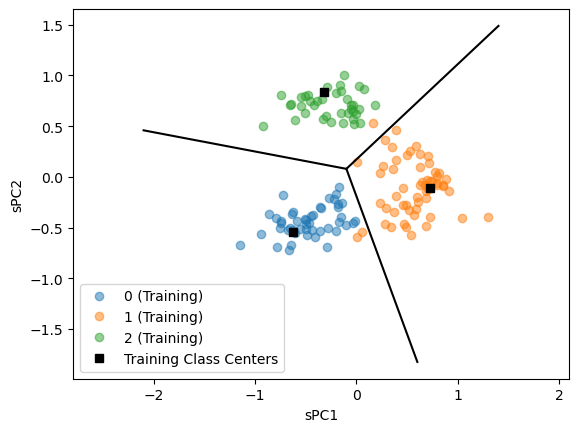

In [111]:
_ = hard_plsda.visualize(styles=['hard'])

In [112]:
# The data frame from FOM is essentially a confusion matrix, but includes as extra column for unknowns.
# For Hard PLS-DA the last column is never populated
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = hard_plsda.figures_of_merit(hard_plsda.predict(X_test), y_test)

In [116]:
# For hard models, TEFF = TSNS = TSPS = accuracy.  This is NOT true for soft models (authenticators in general).
acc = np.sum(hard_plsda.predict(X_test) == y_test) / len(y_test)

print(
    '%.3f'%acc,
    '%.3f'%TSNS,
    '%.3f'%TSPS,
    '%.3f'%TEFF
)

1.000 1.000 1.000 1.000


In [117]:
df

,0,1,2,-1
0,12,0,0,0
1,0,14,0,0
2,0,0,10,0


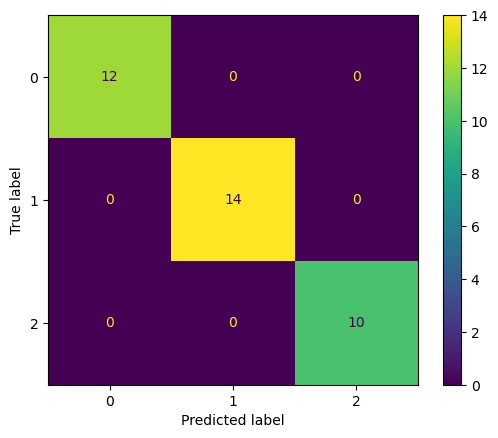

In [118]:
# For Soft PLS-DA we cannot compute a conventional confusion matrix
_ = ConfusionMatrixDisplay.from_estimator(hard_plsda, X_test, y_test)

Model Agnostic Global Explanation  Methods
---

These explain the model in general terms, like how much it relies on certain features on average to make predictions.  Different models often rely on specific model characteristics to explain their behavior, such as loadings plots for PCA, however, there are methods to explain arbitrary models known as "model agnostic" methods.  This are particularly important since, in general, we may train pipelines which perform many different intermediate transformations and we need to be able to explain how this entire process works.

<h3>Permutation Feature Importance (PFI)</h3>

From [sklearn's documentation](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-feature-importance):

> "Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. **The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.** This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature."

[Here](https://scikit-learn.org/stable/modules/permutation_importance.html#outline-of-the-permutation-importance-algorithm) is some pseudocode outlining the basic implementation of PFI.

In [119]:
r = permutation_importance(
    hard_plsda, # This must be a previously fitted estimator or pipeline
    X_test, 
    y_test, 
    n_repeats=30,  # How many times to shuffle each column - do this enough to be confident in your answer
    random_state=42 # For reproducibility
)

Recall the results from [feature selection](feature_selection.ipynb) which yielded similar results.

In [120]:
for feature_, imp_, std_, in sorted(
    zip(X.columns, r['importances_mean'], r['importances_std']), key=lambda x:x[1], reverse=True
):
    print('{} +/- {} :  {}'.format('%.4f'%imp_, '%.4f'%std_, feature_))


0.1037 +/- 0.0386 :  alcohol
0.0750 +/- 0.0314 :  proline
0.0583 +/- 0.0299 :  color_intensity
0.0463 +/- 0.0131 :  alcalinity_of_ash
0.0380 +/- 0.0263 :  hue
0.0370 +/- 0.0219 :  od280/od315_of_diluted_wines
0.0231 +/- 0.0239 :  flavanoids
0.0213 +/- 0.0185 :  nonflavanoid_phenols
0.0111 +/- 0.0184 :  ash
0.0093 +/- 0.0131 :  total_phenols
0.0065 +/- 0.0117 :  malic_acid
0.0065 +/- 0.0117 :  magnesium
0.0056 +/- 0.0111 :  proanthocyanins


PFI can be computed on the training set or held-out test set; however using a held-out test set is important since you can explicitly test to compare which features are important during training vs. when applied to unseen data. Features that are important to predictions made about the training set but not the test set might indicate the model is overfit to the training set, or that the test/train split is poor.

Note the similarity of PFI to [Boruta(SHAP)](feature_selection.ipynb) - Boruta(SHAP) computes feature importances after the model is (re-)trained with the original features plus randomized "shadow" versions of those features.  Features are kept if they are usually are more important than the randomized version of themselves.  Moreover, Boruta(SHAP) retrains the model many times to get average importances.  PFI does not re-train the model and does not use "shadow" features, but does look at the loss in model quality when a feature is essentially replaced by a "shadow" version of itself.

**Importantly,** PFI reflects the loss in model quality when a **single** feature is randomized.  However, if multiple features are correlated, the model still can access this "information" through its correlated features.  Thus, it might seem to the model that a feature is not important because when removed, the model did not get worse, since it relied on the information in other features.  Since feature randomization occurs one at a time, all of these correlated features may then be deemed unimportant and discarded.  **Therefore, it is important that  decorrelated features be used if PFI is to be trusted as a meaningful metric of their importance to a model.** This can be mitigated by performing cluster analysis to identify clusters of correlated features, then [removing all but one](feature_selection.ipynb) for the model to use.  

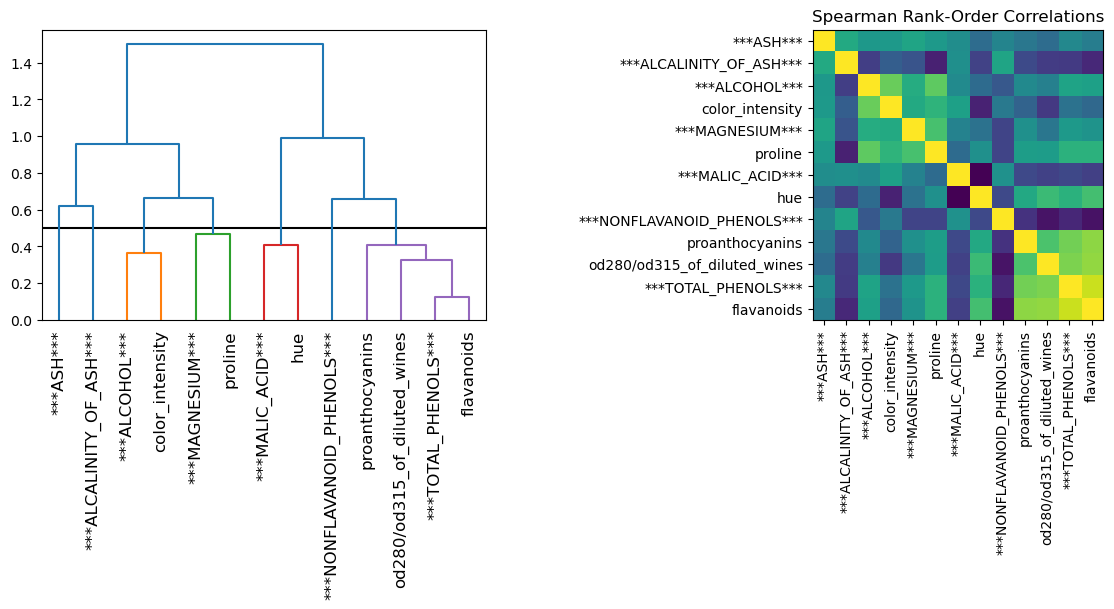

In [134]:
from pychemauth.eda.explore import InspectData

selected_features, cluster_id_to_feature_ids, _ = InspectData.cluster_collinear(
    X=X_train,
    feature_names=X.columns,
    t=0.5,
    figsize=(12,6),
    display=True # We can change this to False so we don't have these plots 
)

In [140]:
selector = SelectFromModel(
    estimator=CollinearFeatureSelector(
        t=0.5, 
        seed=42, 
        minimize_label_entropy=False, 
    ),
    threshold=0.5, # 0's are given to features ignored, 1 if they are kept so set the threshold in between
    prefit=False,
)

selector.fit(X_train)

SelectFromModel(estimator=<pychemauth.preprocessing.feature_selection.CollinearFeatureSelector object at 0x7f90db9c3cd0>,
                threshold=0.5)

In [141]:
X.columns[selector.estimator_.get_support()]

Index(['alcohol', 'ash', 'alcalinity_of_ash', 'magnesium',
       'nonflavanoid_phenols', 'proanthocyanins', 'hue'],
      dtype='object')

In [142]:
_ = hard_plsda.fit(selector.transform(X_train), y_train)
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = hard_plsda.figures_of_merit(
    hard_plsda.predict(selector.transform(X_test)), 
    y_test
)
df # Very similar performance

,0,1,2,-1
0,11,1,0,0
1,0,12,2,0
2,1,0,9,0


In [143]:
r = permutation_importance(
    hard_plsda,
    selector.transform(X_test), 
    y_test, 
    n_repeats=30,  # How many times to shuffle each column - do this enough to be confident in your answer
    random_state=42 # For reproducibility
)

In [144]:
for feature_, imp_, std_, in sorted(
    zip(X.columns, r['importances_mean'], r['importances_std']), key=lambda x:x[1], reverse=True
):
    print('{} +/- {} :  {}'.format('%.4f'%imp_, '%.4f'%std_, feature_))

# Now, really just alcohol and flavanoids are the main features in the model

0.2426 +/- 0.0745 :  alcohol
0.1213 +/- 0.0655 :  flavanoids
0.0296 +/- 0.0405 :  total_phenols
0.0167 +/- 0.0397 :  malic_acid
0.0083 +/- 0.0330 :  ash
0.0046 +/- 0.0443 :  magnesium
0.0037 +/- 0.0224 :  alcalinity_of_ash


<h3>Partial Dependence Plots (PDP)</h3>

From [sklearn's documentation](https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence-plots):

> "Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest."


Let $X_s$ be the set of input features of interest and $X_c$ be the remainder ("complement"). The partial dependence, $P$, of the response, $f$, at a point, $x_s$ is defined as:

$P(x_s) = \int f(x_s, x_c) p(x_c) {\rm d}x_c $ 
 
where $f(x_s, x_c)$ is the response function (such predict, predict_proba or decision_function methods from an estimator). Computing this integral for various values of $x_s$ produces a PDP plot. An Individual Conditional Expectation (ICE) line is defined as a single line evaluated at $x_s$. [In practice](https://scikit-learn.org/stable/modules/partial_dependence.html#computation-methods) this integral is usually computed by summation.

Because of this marginalization, the **biggest assumption is, again, that features are independent.**

* One-way PDPs tell us about the interaction between the target response and an input feature of interest (e.g. linear, non-linear). This is generally helpful for analyzing the qualitative aspects of the data that lead to a prediction.  For example, does the probability of a class rise monotonically or have interesting non-monotonic behavior; or does the probability rise or fall as a certain feature changes?

* PDPs with two input features of interest illustrate interactions between two features.

<h4>Hard PLS-DA</h4>

In [153]:
# You can compute raw partial dependence values like this.
raw = partial_dependence(
    hard_plsda,
    X=selector.transform(X_train), # Assumes independence so best to use decorrelated features
    features=[0],
    response_method='predict_proba', # Use the model's predict_proba() method to compute the response
    method='brute',
    grid_resolution=100,
    kind='average' # This gives partial dependence, 'individual' yields ICE
)

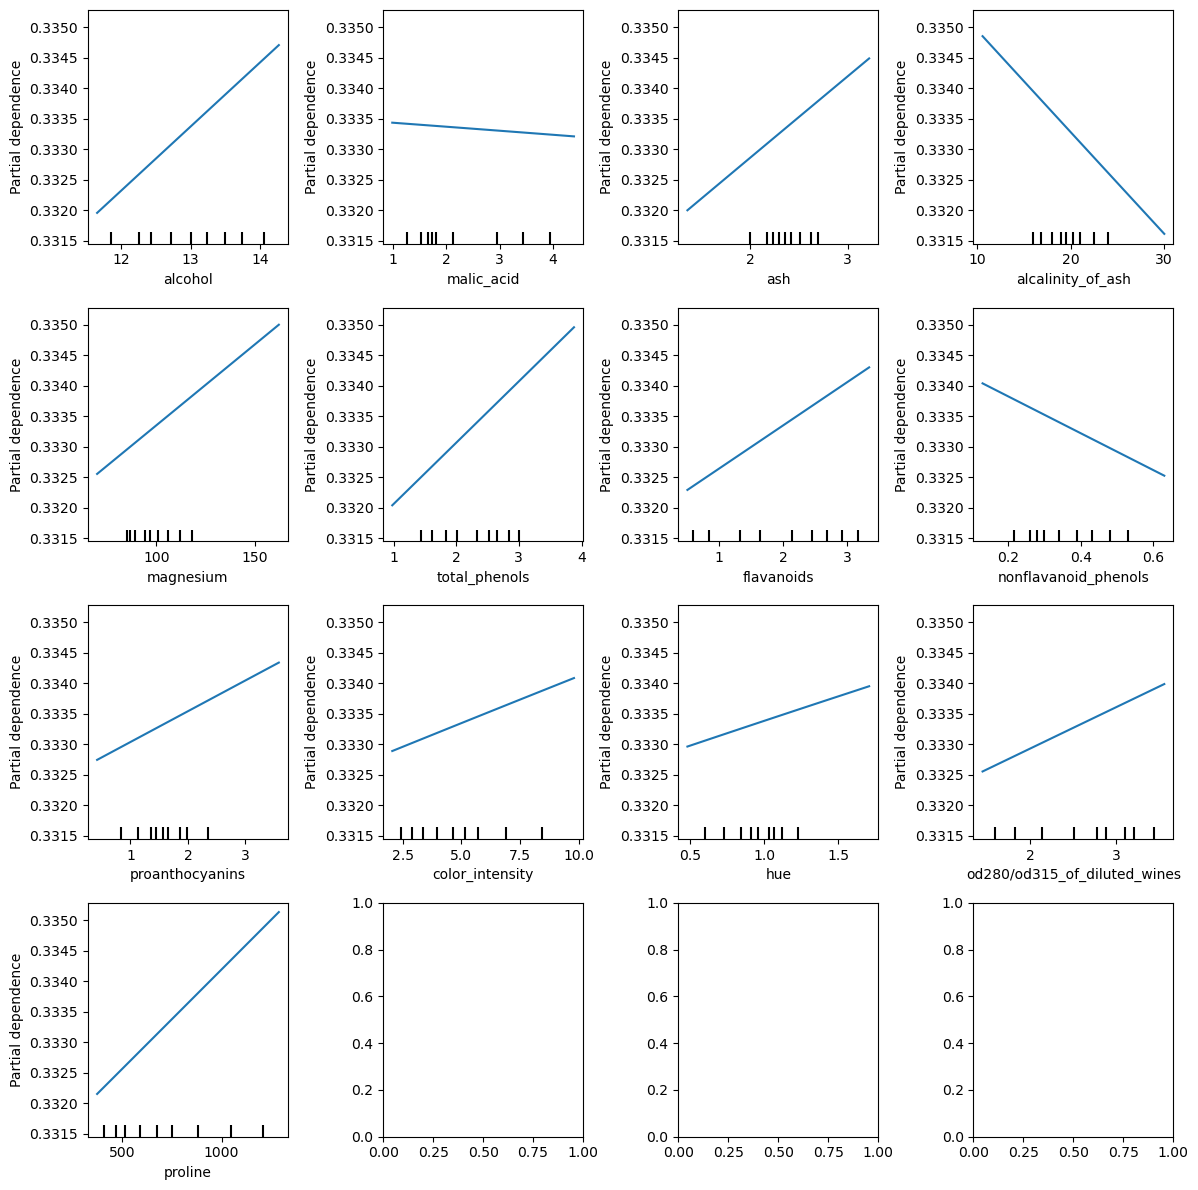

In [276]:
# However, it is generally easier to inspect them visually
model = PLSDA(
    n_components=2,
    alpha=0.05,
    gamma=0.01,
    not_assigned=-1,
    style='hard',
    scale_x=True,
    score_metric='TEFF'
)
_ = model.fit(X_train, y_train)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12))
_ = PartialDependenceDisplay.from_estimator(
    model,
    X=pd.DataFrame(X_train, columns=X.columns),
    features=X.columns, # Look at PDP for each column
    target=0, # Consider class 0
    response_method='predict_proba', # Use the model's predict_proba() method to compute the response
    method='brute',
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False,
    ax=axes.ravel()[:13]
)
plt.tight_layout()

It appears that class 0 becomes more likely as things like 'alcohol' increase and 'alcalinity_of_ash' fall.

<Axes: xlabel='y', ylabel='alcalinity_of_ash'>

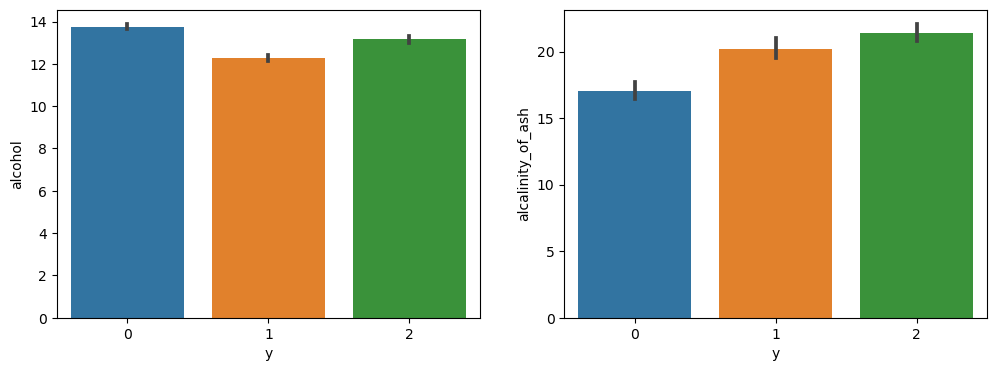

In [344]:
# Indeed, it seems class 0 has the highest alcohol on average, and the lowest alcalinity of ash so this makes sense.
X_df = X.copy()
X_df['y'] = y

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.barplot(data=X_df, x="y", y="alcohol", ax=axes[0])
sns.barplot(data=X_df, x="y", y="alcalinity_of_ash", ax=axes[1])

<h4>Soft PLS-DA</h4>

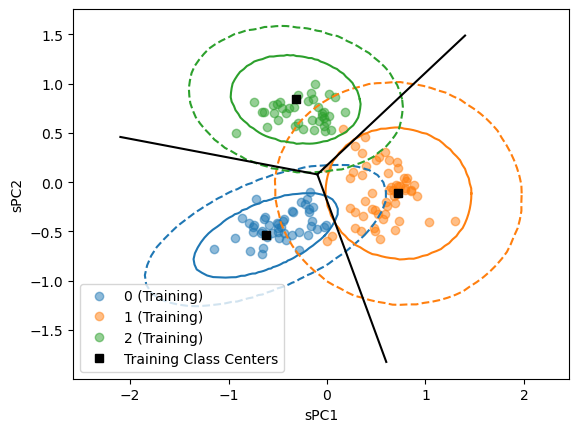

In [345]:
# Soft PLS-DA has very different boundaries, but we can still use PDPs to understand what makes the model think
# a sample belongs to class 0 (in this example)

model = PLSDA(
    n_components=2,
    alpha=0.05,
    gamma=0.01,
    not_assigned=-1,
    style='soft',
    scale_x=True,
    score_metric='TEFF'
)

_ = model.fit(X_train, y_train)

_ = model.visualize(styles=['hard', 'soft'])

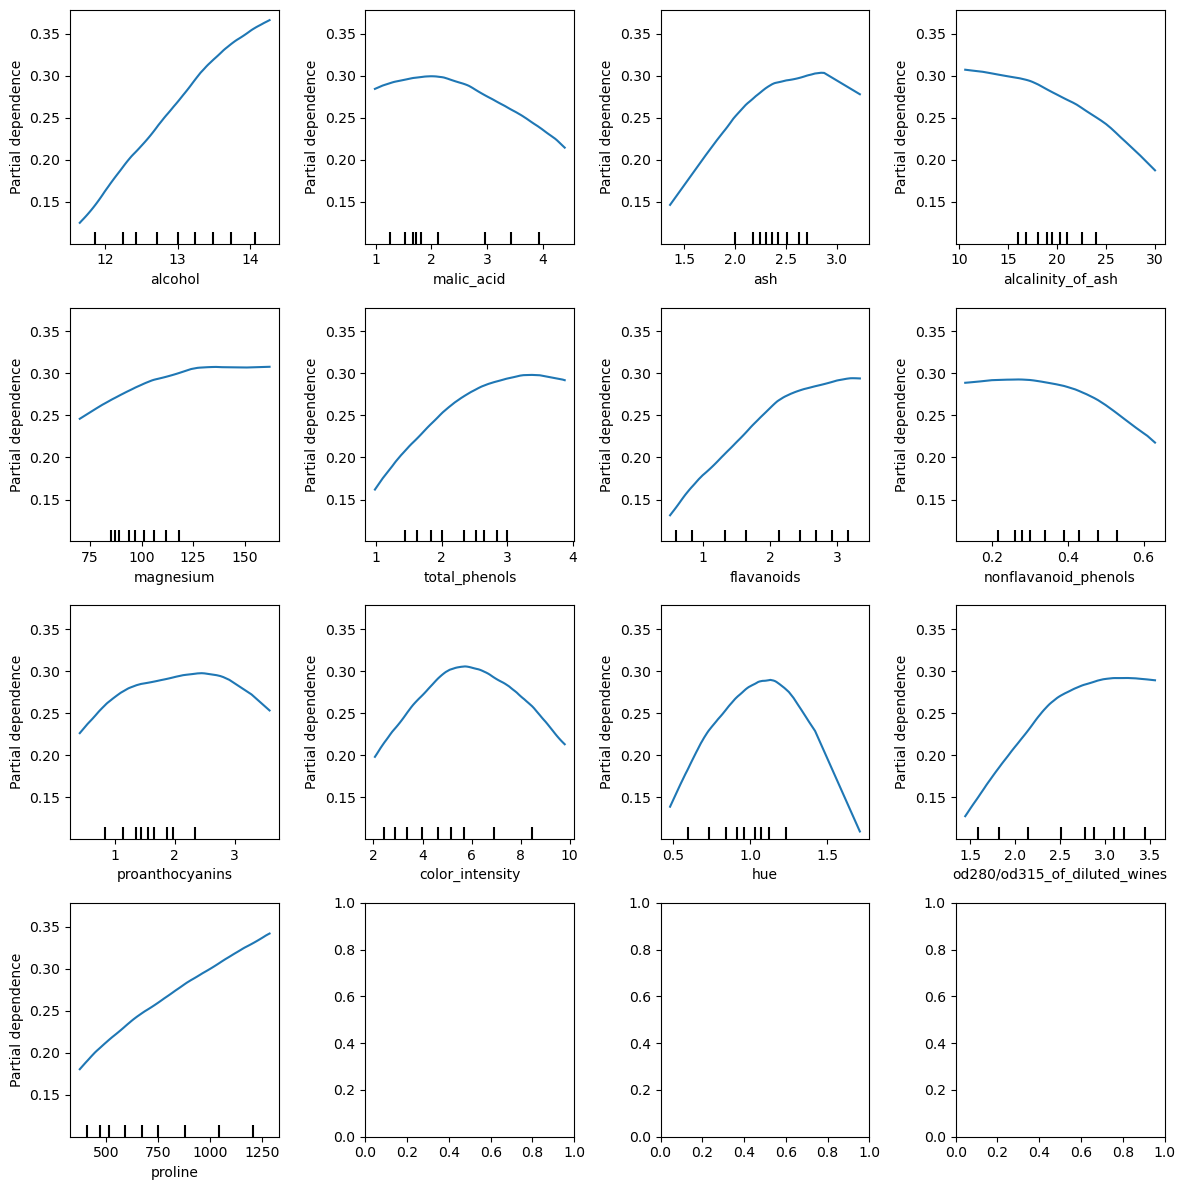

In [346]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12))
_ = PartialDependenceDisplay.from_estimator(
    model,
    X=pd.DataFrame(X_train, columns=X.columns),
    features=X.columns, # Look at PDP for each column
    target=0, # Consider class 0
    response_method='predict_proba', # Use the model's predict_proba() method to compute the response
    method='brute',
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False,
    ax=axes.ravel()[:13]
)
plt.tight_layout()

<Axes: xlabel='y', ylabel='hue'>

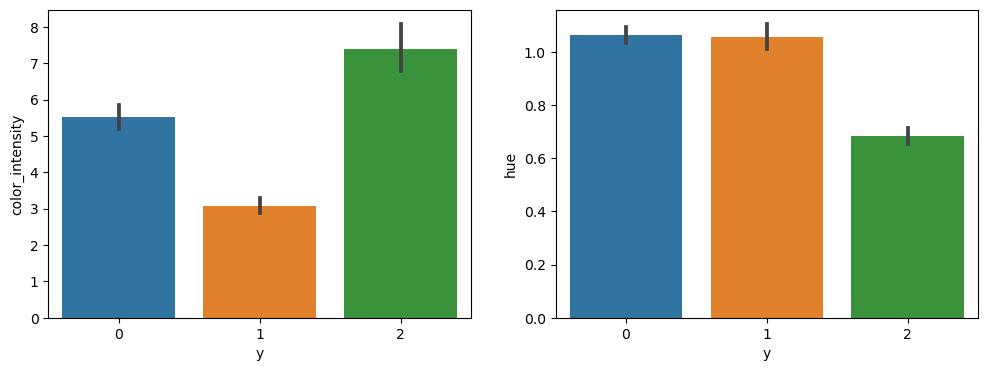

In [348]:
# Indeed, an "intermediate" value of things like hue and color_intensity seem to correspond to class 1.
# The hard model did not capture this because the hard model essentially focuses on building "walls" in between
# classes, rather than characterizing what a class "is".

X_df = X.copy()
X_df['y'] = y

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.barplot(data=X_df, x="y", y="color_intensity", ax=axes[0])
sns.barplot(data=X_df, x="y", y="hue", ax=axes[1])

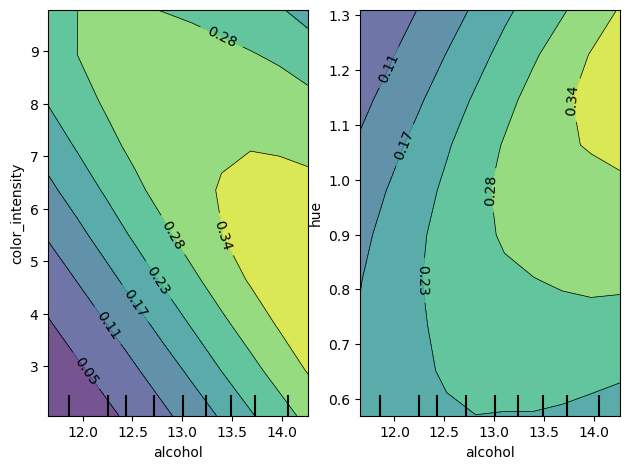

In [349]:
_ = PartialDependenceDisplay.from_estimator(
    model,
    X=pd.DataFrame(X_train, columns=X.columns),
    features=[('alcohol', 'color_intensity'), ('alcohol', 'hue')], 
    target=0, # Consider class 0
    response_method='predict_proba', # Use the model's predict_proba() method to compute the response
    method='brute',
    grid_resolution=10,
    subsample=100,
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False,
)
plt.tight_layout()

Clearly, the soft PLS-DA model "thinks" differently given the same input.  Importantly, the above plots are reflecting the probability that a sample belongs to class 0, but the consistency with a class is based on a critical threshold cutoff.  This is not easy to directly visualize when using probabilities.  However, we can use the `decision_function` instead to analyze the model's behavior.  This returns the negative Mahalanobis distance shifted by the cutoff distance, so f < 0 implies an extreme or outlier while f > 0 implies an inlier.

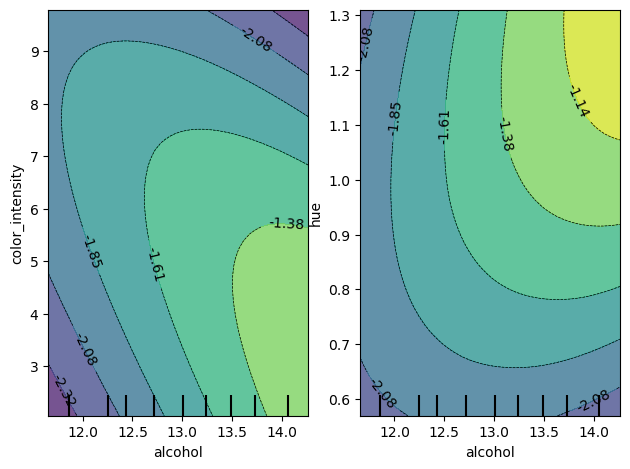

In [350]:
_ = PartialDependenceDisplay.from_estimator(
    model,
    X=pd.DataFrame(X_train, columns=X.columns),
    features=[('alcohol', 'color_intensity'), ('alcohol', 'hue')], 
    target=0, # Consider class 0
    response_method='decision_function', # Use the model's decision_function() method to compute the response
    method='brute',
    grid_resolution=50,
    subsample=100,
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False,
)
plt.tight_layout()

<h4>SIMCA</h4>

In [351]:
compliant = SIMCA_Authenticator(
    n_components=2,
    alpha=0.05,
    scale_x=True,
    style='dd-simca',
    robust="semi",
    sft=False,
    target_class=0, # Let's model class 0
    use='compliant' # Using a compliant approach will use the other classes provided at training time
)

_ = compliant.fit(X_train, y_train)

**PartialDependenceDisplay ignores the target for binary classification.  Authenticators are interepreted as binary since they predict True/False for each point being an inlier.**

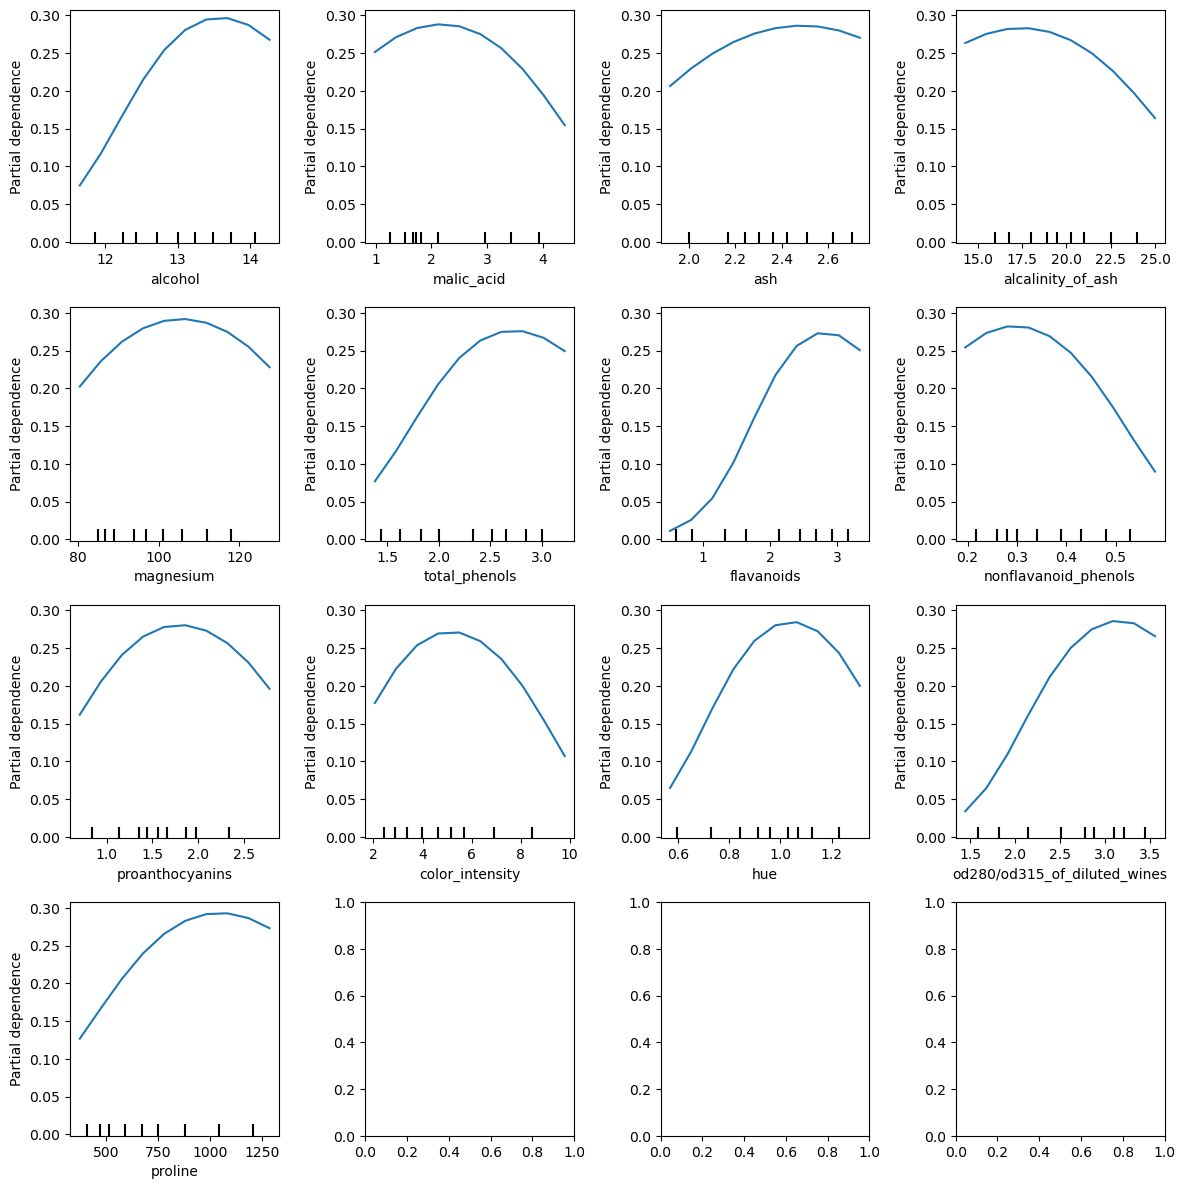

In [352]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12))

_ = PartialDependenceDisplay.from_estimator(
    compliant,
    X=pd.DataFrame(X_train, columns=X.columns), # Assumes independence so best to use decorrelated features
    features=X.columns,
    response_method='predict_proba', # Use the model's predict_proba() method to compute the response
    method='brute',
    grid_resolution=10,
    subsample=100,
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False,
    ax=axes.ravel()[:13]
)
plt.tight_layout()

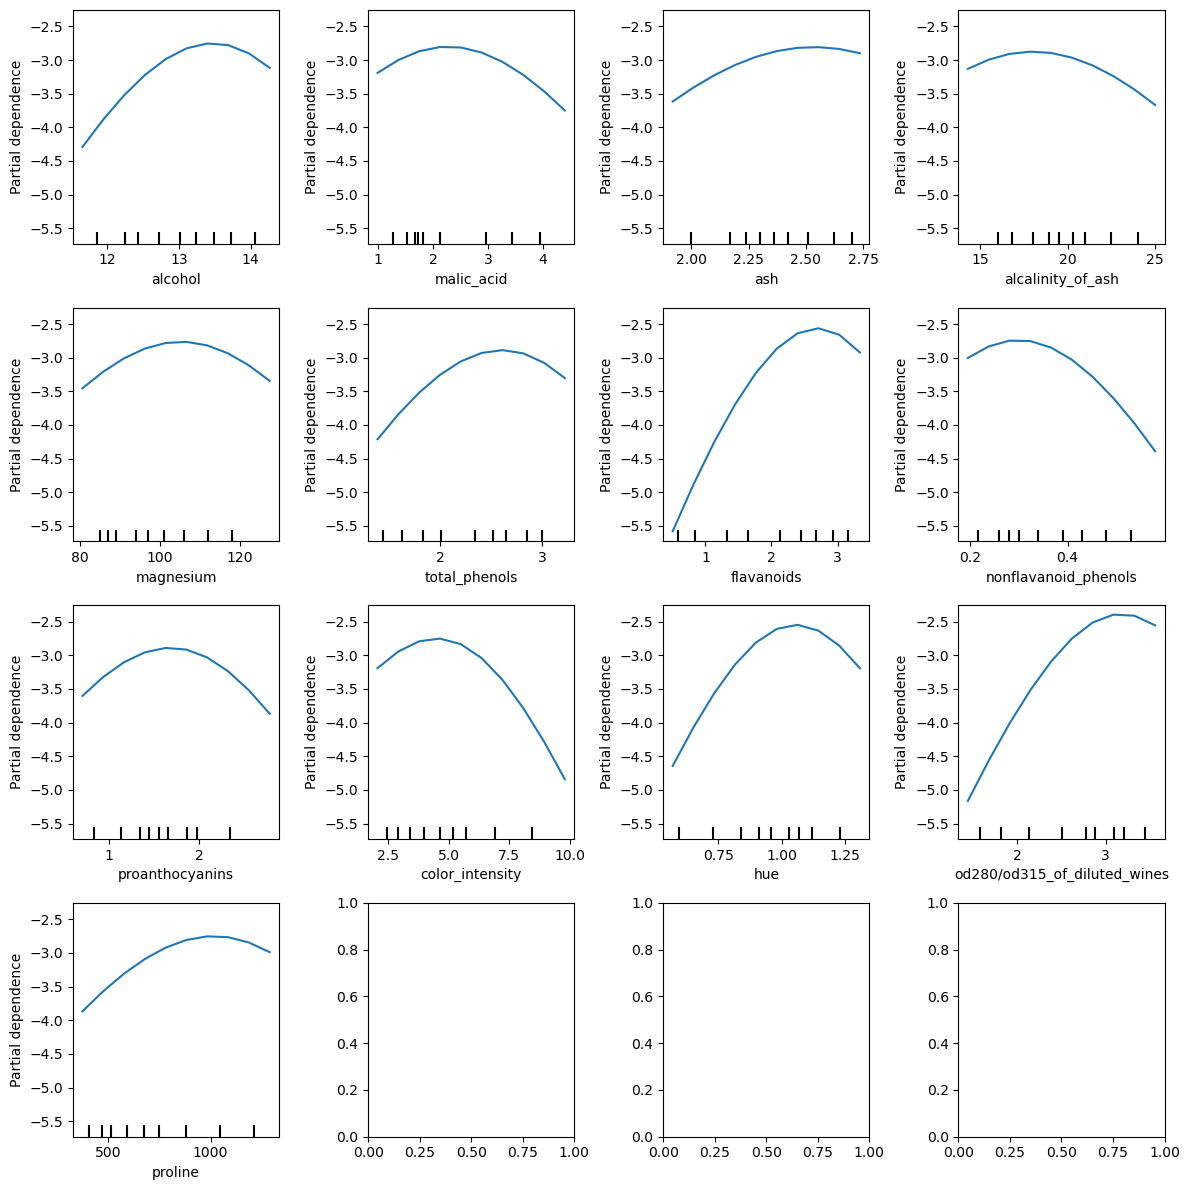

In [353]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12))

_ = PartialDependenceDisplay.from_estimator(
    compliant,
    X=pd.DataFrame(X_train, columns=X.columns), # Assumes independence so best to use decorrelated features
    features=X.columns,
    response_method='decision_function', # Use the model's predict_proba() method to compute the response
    method='brute',
    grid_resolution=10,
    subsample=100,
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False,
    ax=axes.ravel()[:13]
)
plt.tight_layout()

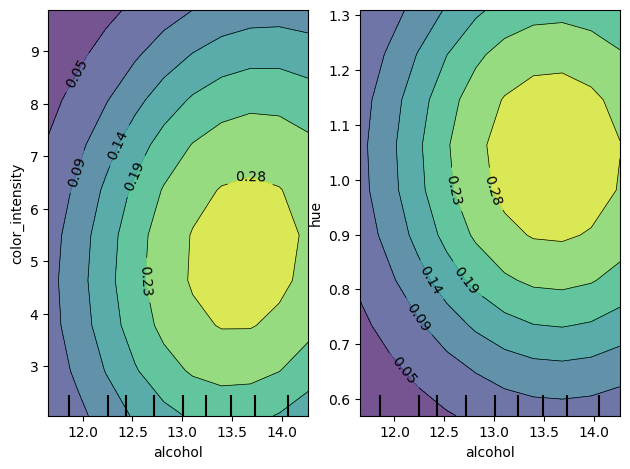

In [354]:
_ = PartialDependenceDisplay.from_estimator(
    compliant,
    X=pd.DataFrame(X_train, columns=X.columns), # Assumes independence so best to use decorrelated features
    features=[('alcohol', 'color_intensity'), ('alcohol', 'hue')],
    response_method='predict_proba', # Use the model's predict_proba() method to compute the response
    method='brute',
    grid_resolution=10,
    subsample=100,
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False
)
plt.tight_layout()

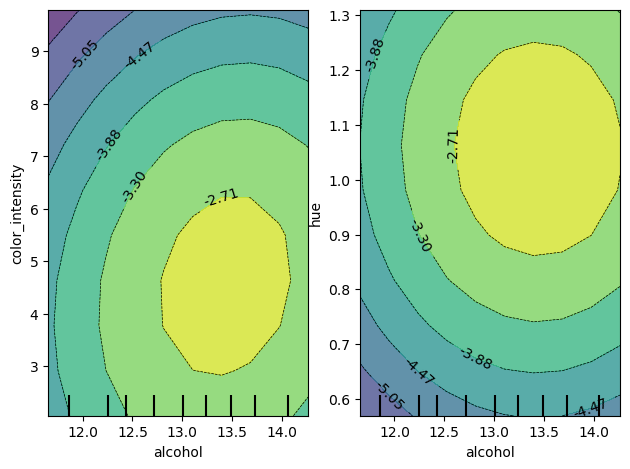

In [355]:
_ = PartialDependenceDisplay.from_estimator(
    compliant,
    X=pd.DataFrame(X_train, columns=X.columns), # Assumes independence so best to use decorrelated features
    features=[('alcohol', 'color_intensity'), ('alcohol', 'hue')],
    response_method='decision_function', 
    method='brute',
    grid_resolution=10,
    subsample=100,
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False
)
plt.tight_layout()

<h3>Shapley Additive exPlanations (SHAP)</h3>

In [ ]:
SHAP - squashing function

Local Explanation Methods
---

These help us explain a single prediction.

In [356]:
SHAP, ICE

NameError: name 'SHAP' is not defined

Learning Curves
---

In [ ]:
learning curve from display